In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        # convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-1-16a7504a1022>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        # convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        # convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


KeyError: 'Total speed (Gb/s)'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned.head()
        # convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


KeyError: 'Total speed (Gb/s)'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned.head()
        # convert bytes to Gb
        # data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        # data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # # Rename columns
        # data_cleaned.rename(columns={
        #     'Total speed (b/s)': 'Total speed (Gb/s)',
        #     'Download speed (b/s)': 'Total speed (Gb/s)'
        #     }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        data_cleaned.head()
        # convert bytes to Gb
        # data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        # data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # # Rename columns
        # data_cleaned.rename(columns={
        #     'Total speed (b/s)': 'Total speed (Gb/s)',
        #     'Download speed (b/s)': 'Total speed (Gb/s)'
        #     }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-6-ac6a16f2062b>:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        print(data_cleaned.head())
        
        # convert bytes to Gb
        # data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        # data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # # Rename columns
        # data_cleaned.rename(columns={
        #     'Total speed (b/s)': 'Total speed (Gb/s)',
        #     'Download speed (b/s)': 'Total speed (Gb/s)'
        #     }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


                       Time  Download (b/s)   Total (b/s)
0 2022-02-01 00:00:00+00:00    0.000000e+00  0.000000e+00
1 2022-02-02 18:00:00+00:00    0.000000e+00  0.000000e+00
2 2022-02-02 22:00:00+00:00    2.159972e+08  4.335945e+08
3 2022-02-03 02:00:00+00:00    1.040372e+08  2.080813e+08
4 2022-02-03 06:00:00+00:00    1.688578e+08  3.405690e+08


<ipython-input-7-b9b3042692aa>:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # print(data_cleaned.head())
        
        convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4h').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


SyntaxError: invalid syntax (<ipython-input-8-5797cd632d07>, line 43)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # print(data_cleaned.head())
        
        # convert bytes to Gb
        data_cleaned['Total speed (b/s)'] = data_cleaned['Total speed (Gb/s)'] / 1e9
        data_cleaned['Download speed (b/s)'] = data_cleaned['Download speed (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total speed (b/s)': 'Total speed (Gb/s)',
            'Download speed (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4h').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


KeyError: 'Total speed (Gb/s)'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # print(data_cleaned.head())
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (Gb/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (Gb/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total speed (Gb/s)',
            'Download (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4h').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


KeyError: 'Total (Gb/s)'

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # print(data_cleaned.head())
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (b/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (b/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total speed (Gb/s)',
            'Download (b/s)': 'Total speed (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4h').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


In [ ]:
def boxplot(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
    """
    Plot a boxplot of the specified column.
    :param df: a pandas dataframe
    :param column: the column to plot
    :return: None
    """
    sns.set_theme(style="whitegrid")
    
    fig, axs = plt.subplots(
        nrows=2, 
        figsize=(10, 8),
        constrained_layout=True
        )
    
    sns.boxplot(x=data_interpolated['Download Speed (G/s)'], ax=axs[0])
    axs[0].set_title('Boxplot de Descarga (G/s)')
    sns.boxplot(x=data_interpolated['Total Speed (G/s)'], ax=axs[1])
    axs[1].set_title('Boxplot de Total (G/s)')

    plt.show()

In [ ]:
def boxplot(df: pd.DataFrame):
    """
    Plot a boxplot of the specified column.
    :param df: a pandas dataframe
    :param column: the column to plot
    :return: None
    """
    sns.set_theme(style="whitegrid")
    
    fig, axs = plt.subplots(
        nrows=2, 
        figsize=(10, 8),
        constrained_layout=True
        )
    
    sns.boxplot(x=df['Download Speed (G/s)'], ax=axs[0])
    axs[0].set_title('Boxplot de Descarga (G/s)')
    sns.boxplot(x=df['Total Speed (G/s)'], ax=axs[1])
    axs[1].set_title('Boxplot de Total (G/s)')

    plt.show()

KeyError: 'Download Speed (G/s)'

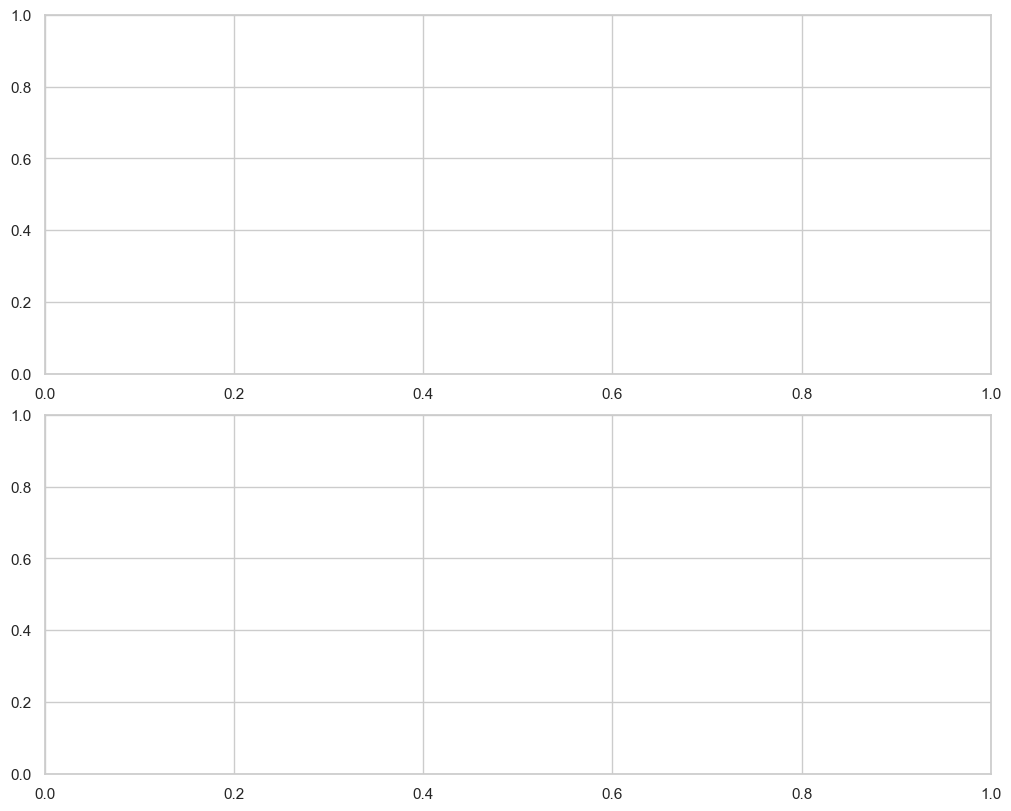

In [ ]:
boxplot(data_interpolated)

In [ ]:
def boxplot(df: pd.DataFrame):
    """
    Plot a boxplot of the specified column.
    :param df: a pandas dataframe
    :param column: the column to plot
    :return: None
    """
    sns.set_theme(style="whitegrid")
    
    fig, axs = plt.subplots(
        nrows=2, 
        figsize=(10, 8),
        constrained_layout=True
        )
    
    sns.boxplot(x=df['Download (G/s)'], ax=axs[0])
    axs[0].set_title('Boxplot de Descarga (G/s)')
    sns.boxplot(x=df['Total (G/s)'], ax=axs[1])
    axs[1].set_title('Boxplot de Total (G/s)')

    plt.show()

KeyError: 'Download (G/s)'

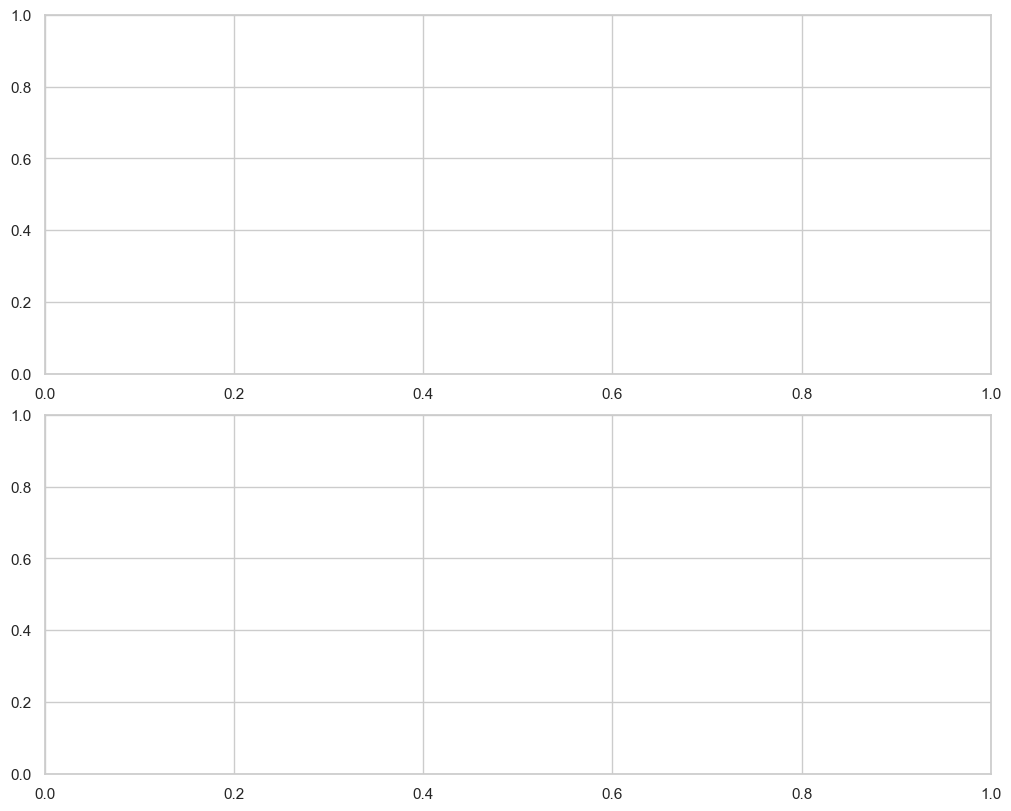

In [ ]:
boxplot(data_interpolated)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (b/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (b/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total (Gb/s)',
            'Download (b/s)': 'Download (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def boxplot(df: pd.DataFrame):
        """
        Plot a boxplot of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        sns.set_theme(style="whitegrid")
        
        fig, axs = plt.subplots(
            nrows=2, 
            figsize=(10, 8),
            constrained_layout=True
            )
        
        sns.boxplot(x=df['Download Speed (G/s)'], ax=axs[0])
        axs[0].set_title('Boxplot de Descarga (G/s)')
        sns.boxplot(x=df['Total Speed (G/s)'], ax=axs[1])
        axs[1].set_title('Boxplot de Total (G/s)')

        plt.show()
        
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(
        #     x=df[column],
        #     color='skyblue',
        #     width=0.5
        # )
        # plt.title(f'Boxplot of {column}')
        # plt.xlabel(xlabel)
        # plt.grid(axis='y', alpha=0.75)
        # plt.show()
    
    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-17-7395f011b047>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


KeyError: 'Download Speed (G/s)'

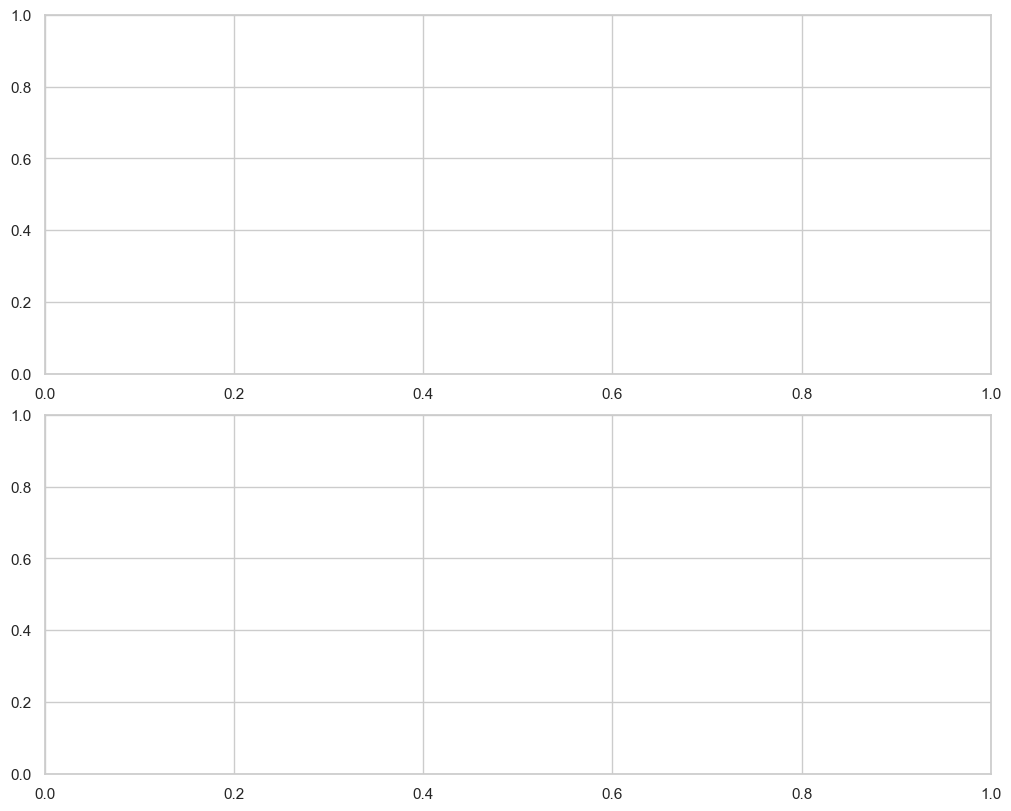

In [ ]:
NET_LSTM.boxplot(data_interpolated)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (b/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (b/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total (Gb/s)',
            'Download (b/s)': 'Download (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def boxplot(df: pd.DataFrame):
        """
        Plot a boxplot of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        sns.set_theme(style="whitegrid")
        
        fig, axs = plt.subplots(
            nrows=2, 
            figsize=(10, 8),
            constrained_layout=True
            )
        
        sns.boxplot(x=df['Download Speed (Gb/s)'], ax=axs[0])
        axs[0].set_title('Boxplot de Descarga (Gb/s)')
        sns.boxplot(x=df['Total Speed (Gb/s)'], ax=axs[1])
        axs[1].set_title('Boxplot de Total (Gb/s)')

        plt.show()
        
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(
        #     x=df[column],
        #     color='skyblue',
        #     width=0.5
        # )
        # plt.title(f'Boxplot of {column}')
        # plt.xlabel(xlabel)
        # plt.grid(axis='y', alpha=0.75)
        # plt.show()
    
    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-19-0c8fc0e77c39>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


KeyError: 'Download Speed (Gb/s)'

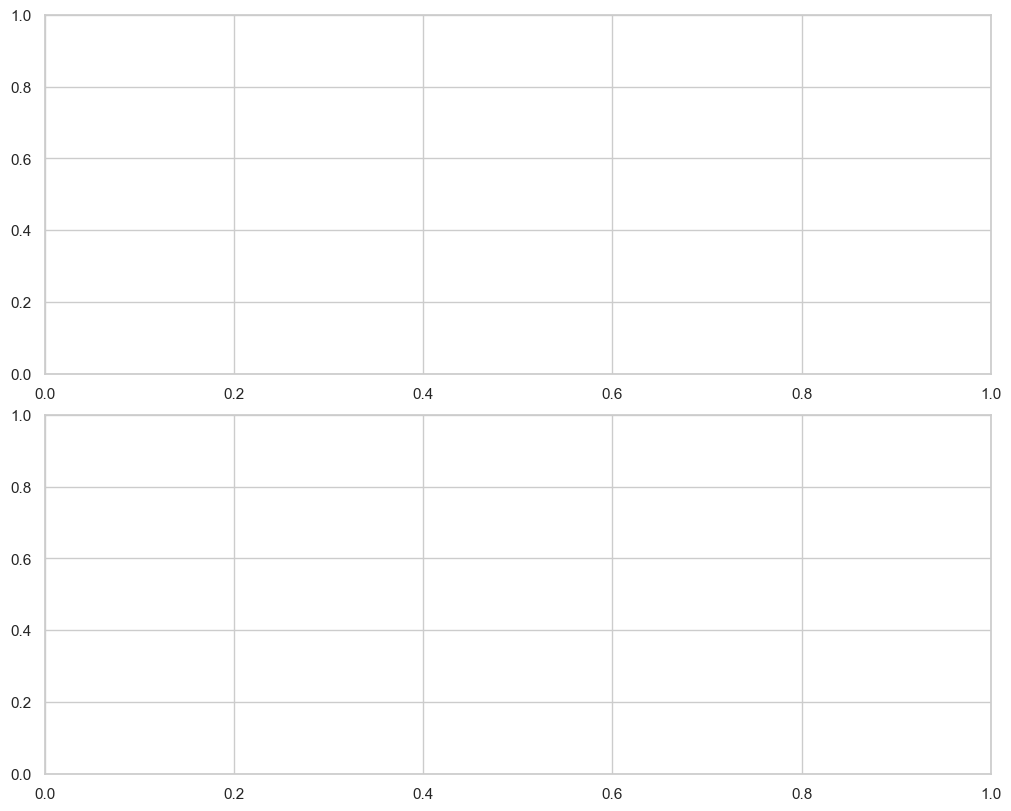

In [ ]:
NET_LSTM.boxplot(data_interpolated)

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (b/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (b/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total (Gb/s)',
            'Download (b/s)': 'Download (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def boxplot(df: pd.DataFrame):
        """
        Plot a boxplot of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        sns.set_theme(style="whitegrid")
        
        fig, axs = plt.subplots(
            nrows=2, 
            figsize=(10, 8),
            constrained_layout=True
            )
        
        sns.boxplot(x=df['Download (Gb/s)'], ax=axs[0])
        axs[0].set_title('Boxplot de Descarga (Gb/s)')
        sns.boxplot(x=df['Total (Gb/s)'], ax=axs[1])
        axs[1].set_title('Boxplot de Total (Gb/s)')

        plt.show()
        
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(
        #     x=df[column],
        #     color='skyblue',
        #     width=0.5
        # )
        # plt.title(f'Boxplot of {column}')
        # plt.xlabel(xlabel)
        # plt.grid(axis='y', alpha=0.75)
        # plt.show()
    
    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (b/s)', 'Total (b/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-21-84d43d072687>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


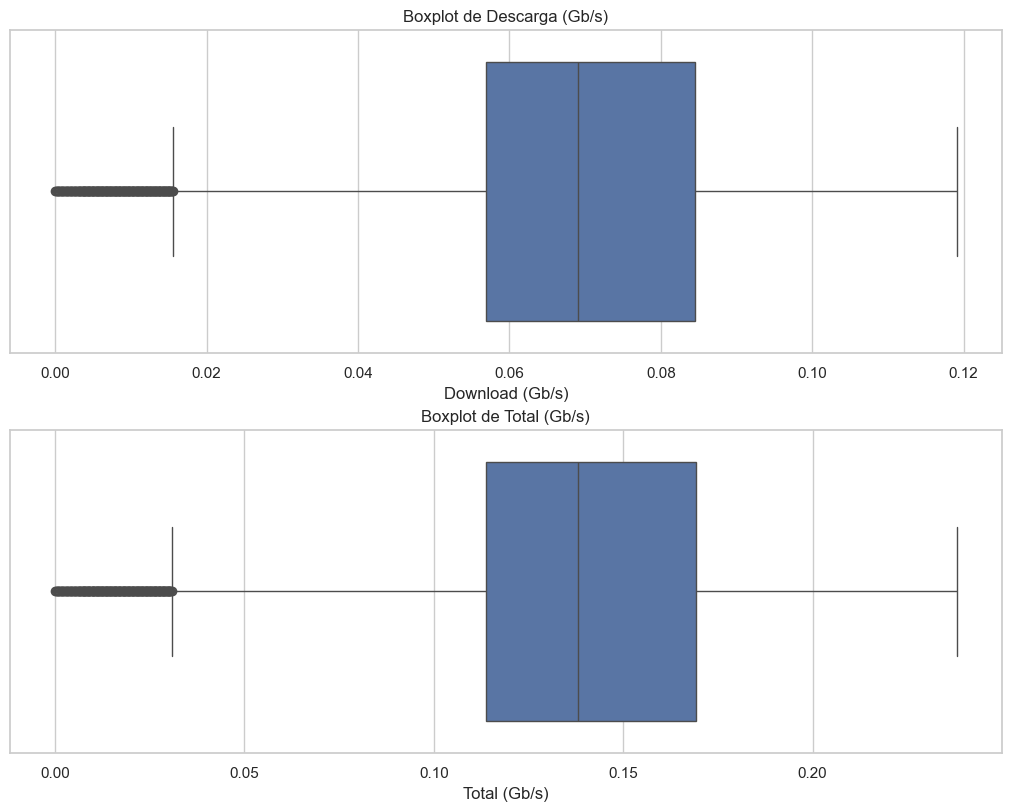

In [ ]:
NET_LSTM.boxplot(data_interpolated)

In [ ]:
features_scaled_df = NET_LSTM.scale_data(data_interpolated)


KeyError: "['Download (b/s)', 'Total (b/s)'] not in index"

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import holidays

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file and preprocess it for LSTM model training.
        This includes renaming columns for consistency, converting the 'time'
        column to datetime format, creating new columns for various time components
        (hour, day of week, etc.), and identifying holidays.

        Parameters:
        - file_path: Path to the csv file containing the dataset.

        Returns:
        - A pandas dataframe with the processed data.
        """
        df = pd.read_csv(file_path)
        
        data_cleaned = df.drop_duplicates()  # Drop duplicates
        
        data_cleaned = data_cleaned.drop_duplicates(
            subset='Time')  # Drop duplicates based on 'Time' column
        
        data_cleaned['Time'] = pd.to_datetime(data_cleaned['Time'])  # Convert 'Time' to datetime format
        
        # convert bytes to Gb
        data_cleaned['Total (b/s)'] = data_cleaned['Total (b/s)'] / 1e9
        data_cleaned['Download (b/s)'] = data_cleaned['Download (b/s)'] / 1e9

        # Rename columns
        data_cleaned.rename(columns={
            'Total (b/s)': 'Total (Gb/s)',
            'Download (b/s)': 'Download (Gb/s)'
            }, inplace=True)

        time_intervals_cleaned = data_cleaned['Time'].diff().value_counts() # Check for time intervals
        
        data_cleaned.set_index('Time', inplace=True) # Set 'Time' as index
        
        data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals

        new_time_intervals = data_interpolated.index.to_series().diff().value_counts() # Check new time intervals
        
        data_interpolated.reset_index(inplace=True) # Reset index
        data_interpolated.head(), new_time_intervals # Display first rows and new time intervals

        col_holidays = holidays.CountryHoliday('CO', years=[2022, 2023, 2024, 2025]) # Colombian holidays
        
        holidays_df = pd.DataFrame(
            sorted(col_holidays.items()), columns=['Date', 'Holiday'])

        holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

        data_interpolated['Holiday'] = data_interpolated['Time'].dt.date.isin(
            holidays_df['Date'].dt.date).astype(int) # Create 'Holiday' column
        
        data_interpolated.head(), holidays_df.head() # Display first rows of the data and holidays dataframes
        return data_interpolated

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def boxplot(df: pd.DataFrame):
        """
        Plot a boxplot of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        sns.set_theme(style="whitegrid")
        
        fig, axs = plt.subplots(
            nrows=2, 
            figsize=(10, 8),
            constrained_layout=True
            )
        
        sns.boxplot(x=df['Download (Gb/s)'], ax=axs[0])
        axs[0].set_title('Boxplot de Descarga (Gb/s)')
        sns.boxplot(x=df['Total (Gb/s)'], ax=axs[1])
        axs[1].set_title('Boxplot de Total (Gb/s)')

        plt.show()
        
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(
        #     x=df[column],
        #     color='skyblue',
        #     width=0.5
        # )
        # plt.title(f'Boxplot of {column}')
        # plt.xlabel(xlabel)
        # plt.grid(axis='y', alpha=0.75)
        # plt.show()
    
    @staticmethod
    def scale_data(df: pd.DataFrame):
        """
        Scale the specified columns of the dataframe
        data_interpolated
        """
        features = df[['Download (Gb/s)', 'Total (Gb/s)', 'Holiday']]   # Select the features
        
        scaler = MinMaxScaler()
        features_scaled = scaler.fit_transform(features)
        features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
        
        features_scaled_df.head() # Display the first rows of the scaled features
        return features_scaled_df
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        """
        Generate sequences from the dataframe to be used as inputs for the LSTM model.
        
        Parameters:
        - df: Pandas DataFrame with scaled features.
        - n_steps: Number of steps/records to be used for each input sequence.
        - target_column: Name of the column to predict.

        Returns:
        - Input sequences (X), target values (y), and corresponding timestamps.
        """
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s', 'hour', 'day_of_week', 'day_of_month', 'month', 'is_holiday']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i].name)  # Timestamps for tracking
        return np.array(X), np.array(y), np.array(timestamps)
    
    @staticmethod
    def predict_future_steps(model, last_sequence, n_steps_into_future=42):
        """
        Genera predicciones futuras para un número dado de pasos en el futuro, basado en la última secuencia observada.

        Parámetros:
        - model: El modelo LSTM entrenado.
        - last_sequence: La última secuencia observada, utilizada como punto de partida para las predicciones.
                        Debe tener la forma (n_steps, n_features).
        - n_steps_into_future: Número de pasos en el futuro para predecir. Por defecto 42, cubriendo una semana con intervalos de 4 horas.

        Retorna:
        - Un DataFrame con las predicciones futuras y sus correspondientes marcas de tiempo.
        """
        n_steps_into_future = 42  # Número de predicciones para cubrir una semana.
        future_predictions = []
        current_sequence = last_sequence.copy()

        for _ in range(n_steps_into_future):
            next_step_pred = model.predict(current_sequence[np.newaxis, :, :])
            future_predictions.append(next_step_pred.flatten()[0])
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1, :] = next_step_pred

        future_timestamps = pd.date_range(
            start='2024-01-26 00:00:00+00:00', periods=n_steps_into_future, freq='4H')
        predictions_df = pd.DataFrame(future_predictions, index=future_timestamps, columns=['Predicted Network Usage (Gb/s)'])

        return predictions_df

    def create_sequences(input_data, target_column, sequence_length):
        sequences = []
        target = []
        for i in range(len(input_data) - sequence_length):
            # Get the sequence
            seq = input_data[i:i + sequence_length]
            # Get the target for the sequence
            label = input_data.iloc[i + sequence_length][target_column]
            sequences.append(seq)
            target.append(label)
        return np.array(sequences), np.array(target)
    
# Load and preprocess data
file_path = './outup/usage_over_time.csv'
data_interpolated = NET_LSTM.load_and_preprocess_data(file_path)


<ipython-input-24-6a123a0d2535>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_interpolated = data_cleaned.resample('4H').interpolate() # Interpolate missing values, resample to 4-hour intervals


In [ ]:
features_scaled_df = NET_LSTM.scale_data(data_interpolated)


In [ ]:
sequence_length = 48 # Number of time steps based on 4-hour intervals (48 * 4h = 192h) = 8 days
features_sequences, target_sequences = NET_LSTM.create_sequences(features_scaled_df, 'Total (Gb/s)', sequence_length)


In [ ]:
split_train = int(0.8 * len(features_sequences))
split_val = int(0.9 * len(features_sequences))

X_train, Y_train = features_sequences[:split_train], target_sequences[:split_train]
X_val, Y_val = features_sequences[split_train:split_val], target_sequences[split_train:split_val]
X_test, Y_test = features_sequences[split_val:], target_sequences[split_val:]

# Display the shapes of the training, validation, and test sets
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape


((3437, 48, 3), (3437,), (430, 48, 3), (430,), (430, 48, 3), (430,))

In [ ]:
# Build the model
model = Sequential([
    LSTM(50, input_shape=(
        X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error') # Compile the model

model.summary() # Display the model summary



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10851 (42.39 KB)
Trainable params: 10851 (42.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    X_train, Y_train, epochs=50, batch_size=32,
    validation_data=(X_val, Y_val), verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test, Y_test)


Epoch 1/50

108/108 [==============================] - 4s 16ms/step - loss: 0.0185 - val_loss: 7.5819e-05
Epoch 2/50
108/108 [==============================] - 1s 12ms/step - loss: 2.2934e-04 - val_loss: 2.8250e-05
Epoch 3/50
108/108 [==============================] - 1s 12ms/step - loss: 1.6603e-04 - val_loss: 3.3354e-05
Epoch 4/50
108/108 [==============================] - 1s 11ms/step - loss: 1.4493e-04 - val_loss: 3.4919e-05
Epoch 5/50
108/108 [==============================] - 1s 12ms/step - loss: 1.2570e-04 - val_loss: 1.7896e-05
Epoch 6/50
108/108 [==============================] - 1s 11ms/step - loss: 9.9374e-05 - val_loss: 1.2085e-05
Epoch 7/50
108/108 [==============================] - 1s 11ms/step - loss: 6.7994e-05 - val_loss: 6.4093e-06
Epoch 8/50
108/108 [==============================] - 1s 12ms/step - loss: 3.6251e-05 - val_loss: 8.5263e-06
Epoch 9/50
108/108 [==============================] - 1s 11ms/step - loss: 2.5460e-05 - val_loss: 2.3229e-06
Epoch 10/50
108/108 [=

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


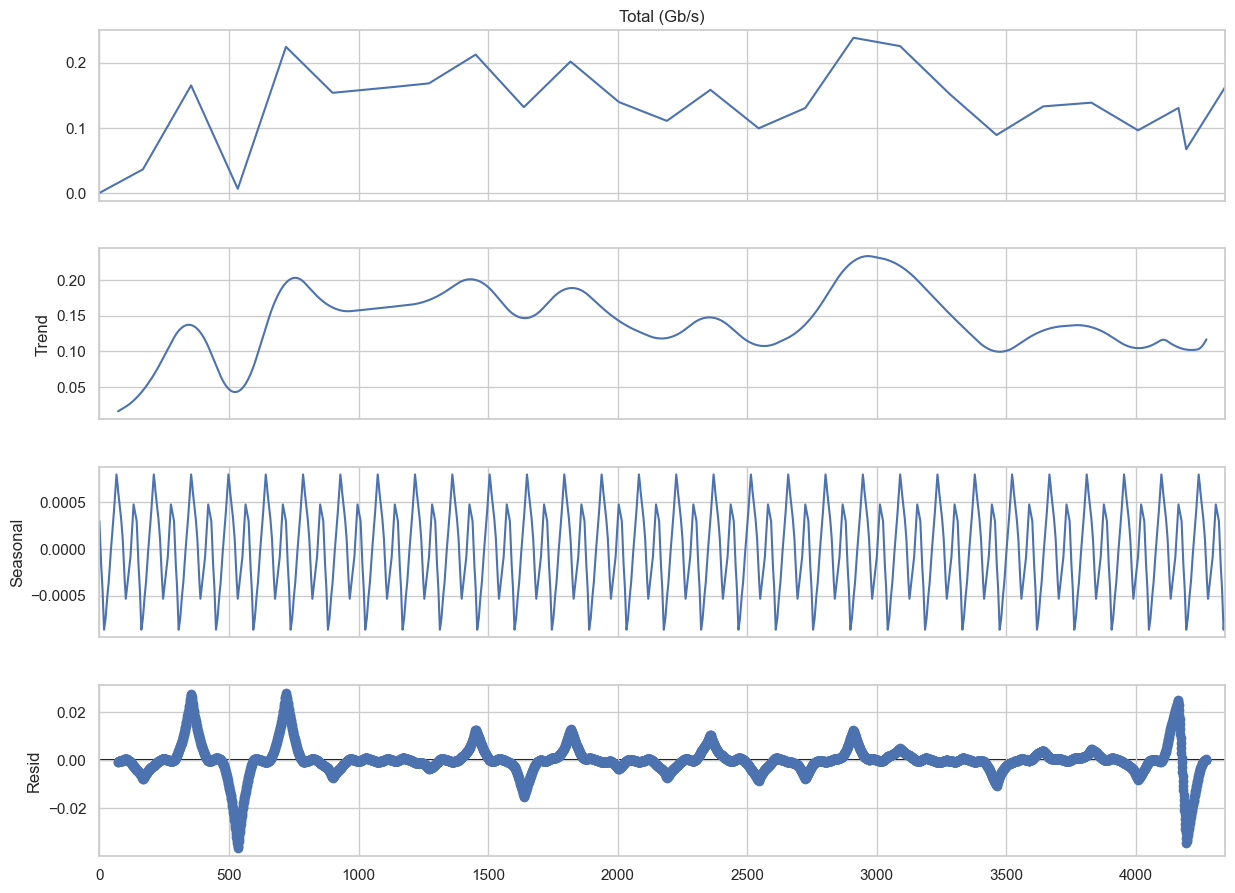

In [ ]:
decomposition = seasonal_decompose(data_interpolated['Total (Gb/s)'], model='additive', period=6*24)
        
decompose_fig = decomposition.plot()
decompose_fig.set_size_inches(14, 10)
plt.show()

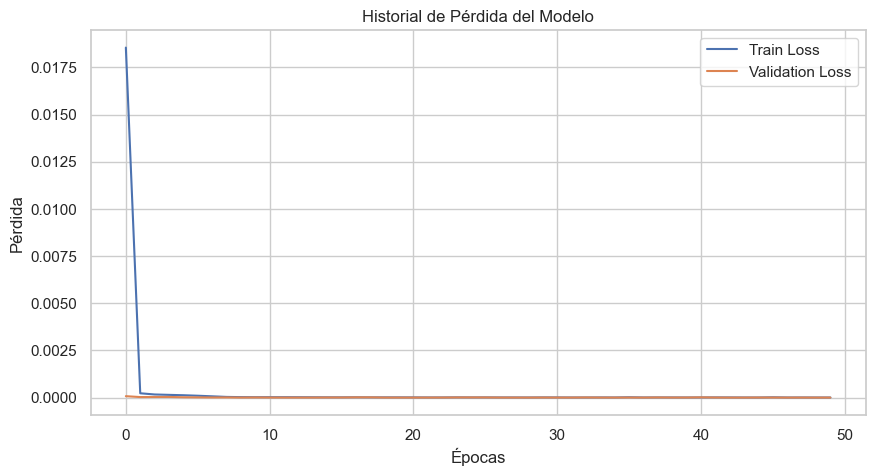

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Historial de Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

14/14 [==============================] - 1s 5ms/step


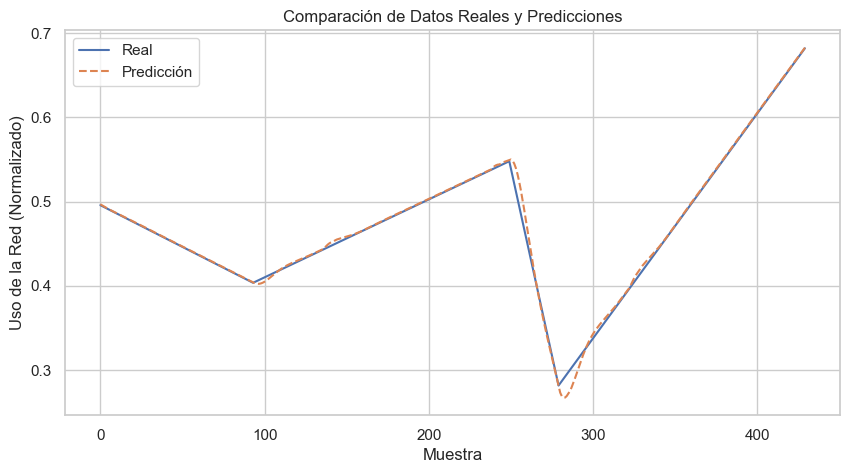

In [ ]:
# Hacer predicciones sobre el conjunto de prueba
predictions = model.predict(X_test)

# Visualizar las predicciones junto con los datos reales
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='Real')
plt.plot(predictions, label='Predicción', linestyle='--')
plt.title('Comparación de Datos Reales y Predicciones')
plt.xlabel('Muestra')
plt.ylabel('Uso de la Red (Normalizado)')
plt.legend()
plt.show()

<ipython-input-35-8b3dcb8ec7ab>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fechas_test = pd.date_range(start='2024-01-01', periods=len(predictions), freq='4H')  # Ajusta según tus datos


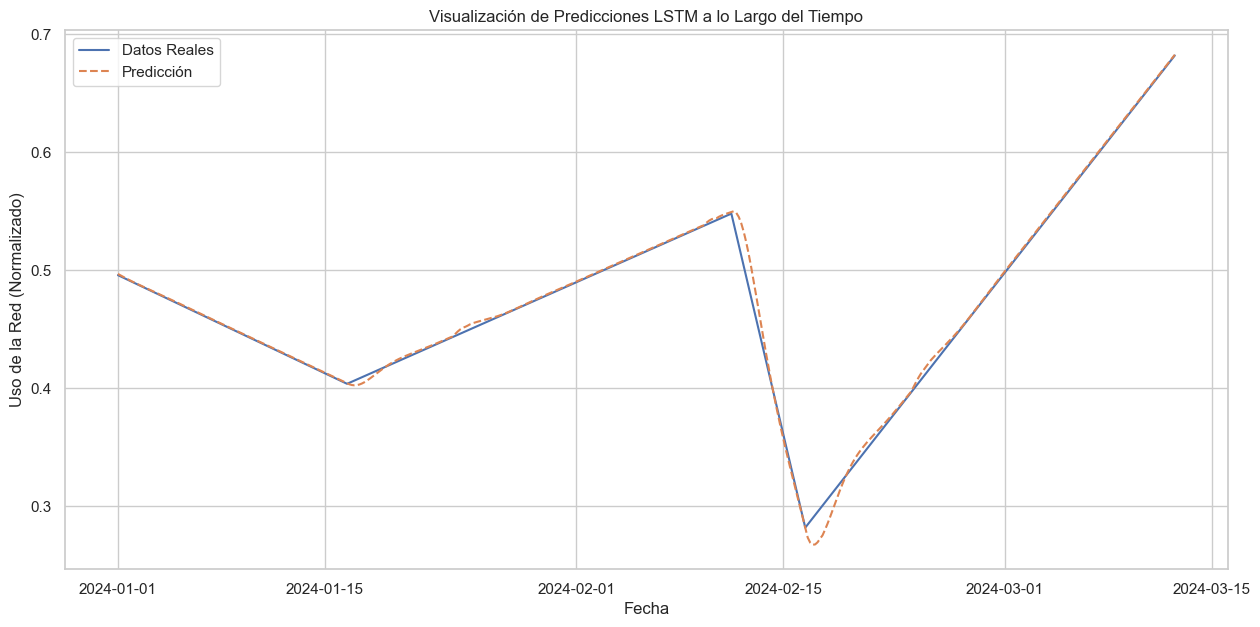

In [ ]:
# Supongamos que tenemos las fechas/horas correspondientes a las entradas en X_test en una lista o array 'fechas_test'
# Puedes obtener estas fechas/horas de tu índice de DataFrame si los datos originales estaban indexados por fecha
fechas_test = pd.date_range(start='2024-01-01', periods=len(predictions), freq='4H')  # Ajusta según tus datos

# Crear un DataFrame para facilitar la visualización
df_predicciones = pd.DataFrame({
    'Fecha': fechas_test,
    'Real': Y_test.flatten(),  # Asegúrate de aplanar Y_test si es necesario
    'Predicción': predictions.flatten()  # Aplanar predictions si es necesario
})

# Graficar
plt.figure(figsize=(15, 7))
plt.plot(df_predicciones['Fecha'], df_predicciones['Real'], label='Datos Reales')
plt.plot(df_predicciones['Fecha'], df_predicciones['Predicción'], label='Predicción', linestyle='--')
plt.title('Visualización de Predicciones LSTM a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Uso de la Red (Normalizado)')
plt.legend()
plt.show()